#### **Imports**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import datetime
import missingno as msno
import tensorflow as tf

# Import from sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, OneHotEncoder, LabelBinarizer, LabelEncoder
import category_encoders as ce
from sklearn.feature_extraction import FeatureHasher
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, ConfusionMatrixDisplay, confusion_matrix, plot_confusion_matrix, multilabel_confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, plot_roc_curve, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from xgboost import XGBClassifier

# Set a random seed
from numpy.random import seed
seed(8)
from tensorflow.random import set_seed
set_seed(8)

# Data Visualization
sns.set_theme(context='notebook', style='darkgrid', palette='bright')

##### **Obtained dataset with mood labels from Kaggle to add to data due to difficulty with Spotify timeouts**

In [2]:
df = pd.read_csv('../data/df_moodadj_cluster.csv')
df.head()

,name,artist,track_id,instrumentalness,danceability,energy,liveness,loudness,acousticness,valence,speechiness,tempo,key,time_signature,length,popularity,mood,mood_map,cluster
0,Kiss Me More (feat. SZA),Doja Cat,748mdHapucXQri7IAO8yFK,0.000158,0.762,0.701,0.1230,-3.541,0.23500,0.742,0.0286,110.968,8,4,208866,92,Energetic,2,0
1,seaside_demo,SEB,73M0rMVx5CWE8M4uATSsto,0.000133,0.706,0.824,0.1110,-7.959,0.35500,0.860,0.0694,94.980,0,4,132000,54,Energetic,2,0
2,Shivers,Ed Sheeran,6bQfNiqyCX7UaQSvVVGo4I,0.000000,0.788,0.859,0.0424,-2.724,0.28100,0.822,0.0856,141.020,2,4,207853,78,Energetic,2,0
3,Heat Waves,Glass Animals,02MWAaffLxlfxAUY7c5dvx,0.000007,0.761,0.525,0.0921,-6.900,0.44000,0.531,0.0944,80.870,11,4,238805,85,Energetic,2,0
4,Electric Love,BØRNS,2GiJYvgVaD2HtM8GqD9EgQ,0.001370,0.611,0.797,0.2600,-7.627,0.00543,0.518,0.0533,120.041,6,4,218106,82,Energetic,2,0


#### **Null model:** 
###### Evaluate class imbalances
###### Classes are fairly balanced

In [3]:
df['mood'].value_counts(normalize=True)

Energetic    0.472559
Chill        0.283125
Sad          0.244315
Name: mood, dtype: float64

#### **Pre-processing**

In [4]:
# X audio features
X_audio = df[['danceability', 
          'energy', 
          'loudness', 
          'speechiness', 
          'acousticness',
          'instrumentalness', 
          'liveness', 
          'valence', 
          'tempo',
          'key',
          'cluster']]

# response variable
y = df['mood_map']


pf = PolynomialFeatures(degree = 3)
X = pf.fit_transform(X_audio)

# # set up train_test_split with stratification to include equal classes of each
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    stratify=y, 
                                                    random_state=42)

# standardize X data
x = MinMaxScaler()
X_train_x = x.fit_transform(X_train)
X_test_x = x.transform(X_test)

# instantiate PCA
pca = PCA(n_components=40, random_state = 42)
Z_train = pca.fit_transform(X_train_x)
Z_test = pca.transform(X_test_x)

# LabelBinarizer for multiclass classification response variable
binarize = LabelBinarizer()
y_train_binarize = binarize.fit_transform(y_train)
y_test_binarize = binarize.transform(y_test)

In [5]:
def mood_model():
    
    n_input = Z_train[0].shape

    model = Sequential()

    model.add(Dense(12, 
                    activation='relu', 
                    input_shape=(n_input)))

    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=[['accuracy'],
                           [tf.keras.metrics.Precision()],
                           [tf.keras.metrics.Recall()]])

    return model

In [6]:
classifier = KerasClassifier(build_fn=mood_model,
                             epochs=200,
                             verbose=0)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, 
                               verbose=1, mode='auto')
history=classifier.fit(Z_train,
               y_train_binarize,
               validation_data=(Z_test, y_test_binarize),
               epochs=200,
               batch_size=8,
               callbacks=[early_stop],
               verbose=0)
print(f'Train score: {classifier.score(Z_train, y_train_binarize)}')
print(f'Test score: {classifier.score(Z_test, y_test_binarize)}')

Epoch 00017: early stopping
Train score: 0.7459697127342224
Test score: 0.7339031100273132


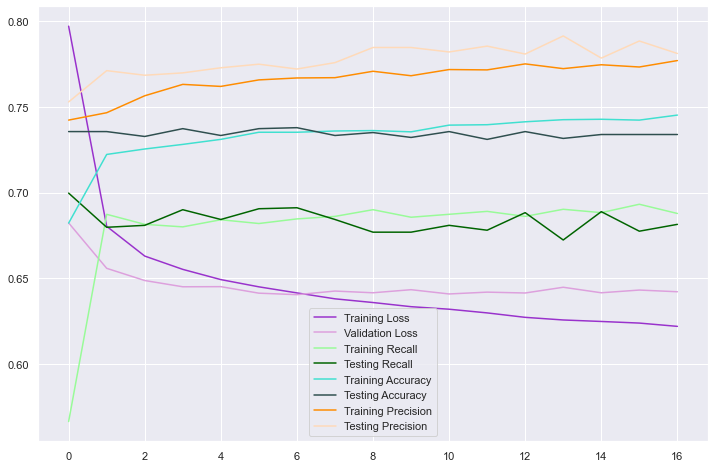

In [7]:
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
train_recall = history.history['recall']
test_recall = history.history['val_recall']
train_precision = history.history['precision']
test_precision = history.history['val_precision']
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='Training Loss', color="darkorchid")
plt.plot(history.history['val_loss'], label='Validation Loss', color='plum')
plt.plot(train_recall, label='Training Recall', color='palegreen')
plt.plot(test_recall, label='Testing Recall', color = 'darkgreen')
plt.plot(train_acc, label='Training Accuracy', color='turquoise')
plt.plot(test_acc, label='Testing Accuracy', color="darkslategray");
plt.plot(train_precision, label='Training Precision', color="darkorange")
plt.plot(test_precision, label='Testing Precision', color='peachpuff')
plt.legend();

In [9]:
print(f'Train score: {classifier.model.evaluate(Z_train, y_train_binarize)}')
print(f'Test score: {classifier.model.evaluate(Z_test, y_test_binarize)}')

128/128 [==============================] - 0s 1ms/step - loss: 0.6162 - accuracy: 0.7460 - precision: 0.7794 - recall: 0.6947
Train score: [0.6162028908729553, 0.7459697127342224, 0.7793915867805481, 0.6946751475334167]
55/55 [==============================] - 0s 955us/step - loss: 0.6422 - accuracy: 0.7339 - precision: 0.7812 - recall: 0.6815
Test score: [0.6421626210212708, 0.7339031100273132, 0.7811887860298157, 0.6814814805984497]


In [13]:
y_preds=classifier.predict(Z_test)

In [14]:
classifier.classes_

array([0, 1, 2])

In [15]:
accuracy_score(y_test, y_preds)

0.7339031339031339

In [16]:
print(f'Sad: {precision_score(y_test, y_preds, average=None)[0]}')
print(f'Calm: {precision_score(y_test, y_preds, average=None)[1]}')
print(f'Energetic: {precision_score(y_test, y_preds, average=None)[2]}')

Sad: 0.7060185185185185
Calm: 0.803030303030303
Energetic: 0.7280453257790368


In [17]:
print(f'Sad: {recall_score(y_test, y_preds, average=None)[0]}')
print(f'Calm: {recall_score(y_test, y_preds, average=None)[1]}')
print(f'Energetic: {recall_score(y_test, y_preds, average=None)[2]}')

Sad: 0.710955710955711
Calm: 0.42655935613682094
Energetic: 0.9300361881785284


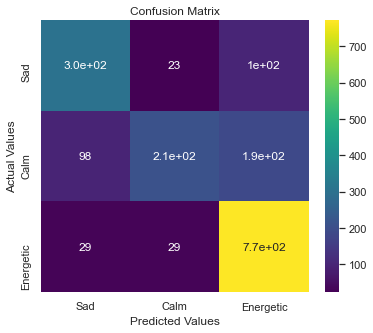

In [18]:
cm = confusion_matrix(y_test, y_preds, labels=classifier.classes_)
cm_df = pd.DataFrame(cm, index=['Sad', 'Calm', 'Energetic'], columns=['Sad', 'Calm', 'Energetic'])
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, cmap='viridis')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [19]:
print(f'Sad: {f1_score(y_test, y_preds, average=None)[0]}')
print(f'Calm: {f1_score(y_test, y_preds, average=None)[1]}')
print(f'Energetic: {f1_score(y_test, y_preds, average=None)[2]}')

Sad: 0.708478513356562
Calm: 0.5571616294349541
Energetic: 0.8167372881355933


In [20]:
print(f"Macro: {f1_score(y_test, y_preds, average='macro')}")
print(f"Weighted: {f1_score(y_test, y_preds, average='weighted')}")

Macro: 0.6941258103090364
Weighted: 0.7167645720362075


In [21]:
pred_df = pd.DataFrame({'true_values'     : y_test,
                        'prediction_prob' : classifier.predict_proba(Z_test)[:,1]})

In [22]:
pred_df.head()

,true_values,prediction_prob
1580,0,0.086332
3994,1,0.467377
5064,2,0.147197
2092,2,0.058465
3526,1,0.697546


In [23]:
y_pred_probs = classifier.predict_proba(Z_test)

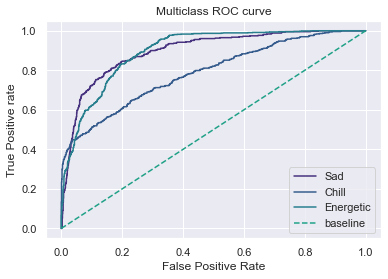

In [24]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_probs[:,i], pos_label=i)
    
# plotting  
sns.set_palette('viridis')
plt.plot(fpr[0], tpr[0], linestyle='-',label='Sad')
plt.plot(fpr[1], tpr[1], linestyle='-',label='Chill')
plt.plot(fpr[2], tpr[2], linestyle='-',label='Energetic')

# add worst case scenario line
plt.plot([0, 1], [0, 1], label="baseline", linestyle="--")

plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC'); 

In [149]:
# X audio features
X_audio = df[['danceability', 
          'energy', 
          'loudness', 
          'speechiness', 
          'acousticness',
          'instrumentalness', 
          'liveness', 
          'valence', 
          'cluster']]

# response variable
y = df['mood_map']


pf = PolynomialFeatures(degree = 3)
X = pf.fit_transform(X_audio)

# # set up train_test_split with stratification to include equal classes of each
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    stratify=y, 
                                                    random_state=42)

# standardize X data
x = MinMaxScaler()
X_train_x = x.fit_transform(X_train)
X_test_x = x.transform(X_test)

# instantiate PCA
pca = PCA(n_components=40, random_state = 42)
Z_train = pca.fit_transform(X_train_x)
Z_test = pca.transform(X_test_x)

# LabelBinarizer for multiclass classification response variable
binarize = LabelBinarizer()
y_train_binarize = binarize.fit_transform(y_train)
y_test_binarize = binarize.transform(y_test)

In [150]:
def mood_model():
    
    n_input = Z_train[0].shape

    model = Sequential()

    model.add(Dense(12, 
                    activation='relu', 
                    input_shape=(n_input)))
    model.add(Dropout(0.2))
    
    model.add(Dense(9, activation='relu'))
    model.add(Dropout(0.1))
    
    model.add(Dense(12, activation='relu'))
    model.add(Dense(6, activation='relu'))

    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=[['accuracy'],
                           [tf.keras.metrics.Precision()],
                           [tf.keras.metrics.Recall()]])

    return model

In [151]:
classifier_2 = KerasClassifier(build_fn=mood_model,
                             epochs=200,
                             verbose=0)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, 
                               verbose=1, mode='auto')
history_2=classifier_2.fit(Z_train,
               y_train_binarize,
               validation_data=(Z_test, y_test_binarize),
               epochs=200,
               batch_size=32,
               callbacks=[early_stop],
               verbose=0)
print(f'Train score: {classifier_2.score(Z_train, y_train_binarize)}')
print(f'Test score: {classifier_2.score(Z_test, y_test_binarize)}')

Epoch 00041: early stopping
Train score: 0.7506106495857239
Test score: 0.7452991604804993


In [152]:
y_preds_2=classifier_2.predict(Z_test)

C:\Users\Brianna\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


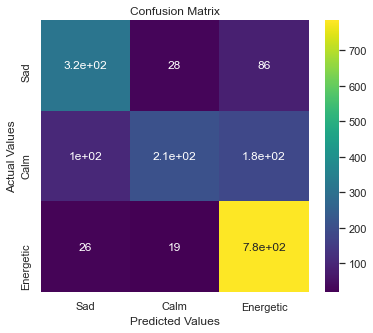

In [154]:
cm = confusion_matrix(y_test, y_preds_2, labels=classifier_2.classes_)
cm_df = pd.DataFrame(cm, index=['Sad', 'Calm', 'Energetic'], columns=['Sad', 'Calm', 'Energetic'])
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, cmap='viridis')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [155]:
pred_df_2 = pd.DataFrame({'true_values'     : y_test,
                        'prediction_prob' : classifier_2.predict_proba(Z_test)[:,1]})

In [156]:
# Generate class membership probabilities
y_pred_probs_2 = classifier_2.predict_proba(Z_test)

roc_curve_weighted=roc_auc_score(y_test, y_pred_probs_2, average="weighted", multi_class="ovr")
roc_curve_macro=roc_auc_score(y_test, y_pred_probs_2, average='macro', multi_class="ovr")
print(roc_curve_weighted)
print(roc_curve_macro)

0.8658605847701489
0.8597826410118546


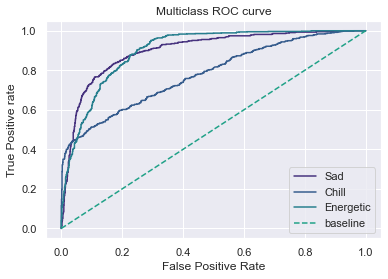

In [157]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_probs_2[:,i], pos_label=i)
    
# plotting  
sns.set_palette('viridis')
plt.plot(fpr[0], tpr[0], linestyle='-',label='Sad')
plt.plot(fpr[1], tpr[1], linestyle='-',label='Chill')
plt.plot(fpr[2], tpr[2], linestyle='-',label='Energetic')

# add worst case scenario line
plt.plot([0, 1], [0, 1], label="baseline", linestyle="--")

plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC'); 